# W12 – Time Series Forecasting

## Imports & Data Loading

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Load the PJMW hourly dataset (make sure the CSV is in the same folder)
df = pd.read_csv('PJMW_hourly.csv')

# Parse datetime and set as index
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime').sort_index()

# Univariate time series: hourly load (MW)
ts = df['PJMW_MW']
ts_2017 = ts['2017']  # focus on 2017 for clearer plots

print(df.head())
print(df.tail())
print('Index range:', df.index.min(), '->', df.index.max())
print('Number of observations:', len(df))

                     PJMW_MW
Datetime                    
2002-04-01 01:00:00   4374.0
2002-04-01 02:00:00   4306.0
2002-04-01 03:00:00   4322.0
2002-04-01 04:00:00   4359.0
2002-04-01 05:00:00   4436.0
                     PJMW_MW
Datetime                    
2018-08-02 20:00:00   6545.0
2018-08-02 21:00:00   6496.0
2018-08-02 22:00:00   6325.0
2018-08-02 23:00:00   5892.0
2018-08-03 00:00:00   5489.0
Index range: 2002-04-01 01:00:00 -> 2018-08-03 00:00:00
Number of observations: 143206


## Univariate Time Series Plot

We show a simple **time series plot** to explain what a univariate time series looks like.
Here we:
- Plot the hourly series for 2017.
- Zoom into the **first week** of 2017 to see daily patterns more clearly.

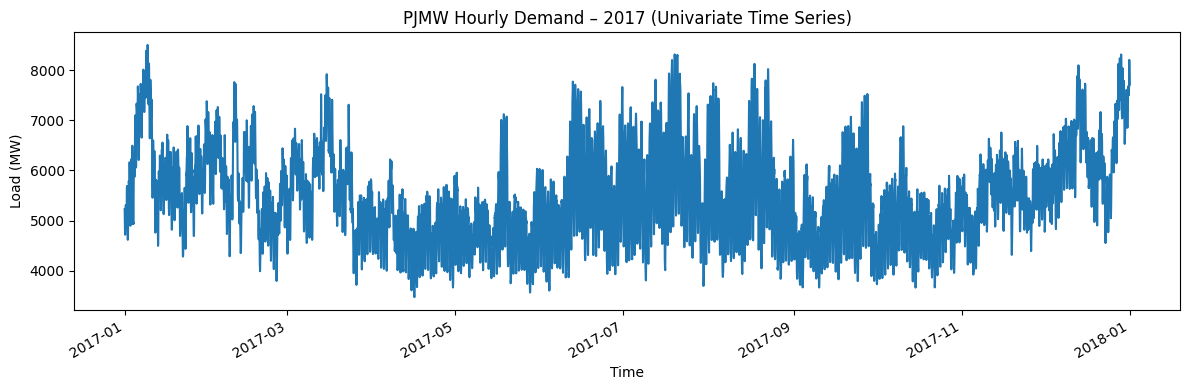

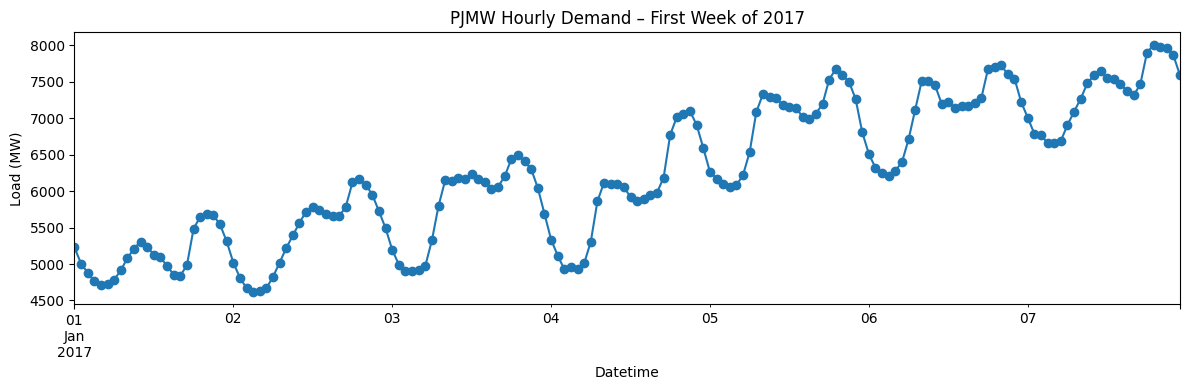

In [20]:
# Plot full 2017 hourly series
plt.figure(figsize=(12, 4))
ts_2017.plot()
plt.title('PJMW Hourly Demand – 2017 (Univariate Time Series)')
plt.xlabel('Time')
plt.ylabel('Load (MW)')
plt.tight_layout()
plt.show()

# Plot first week of 2017 (daily seasonality becomes more visible)
week = ts_2017['2017-01-01':'2017-01-07']

plt.figure(figsize=(12, 4))
week.plot(marker='o')
plt.title('PJMW Hourly Demand – First Week of 2017')
plt.xlabel('Datetime')
plt.ylabel('Load (MW)')
plt.tight_layout()
plt.show()

## Trend and Moving Average Detrending

introduce **trend** and show how a **moving average** can be used to estimate it.

Steps:
1. Aggregate hourly load to **daily mean**.
2. Compute **7-day** and **30-day** moving averages.
3. Subtract the 30-day moving average from the original daily series to obtain a **detrended** series.

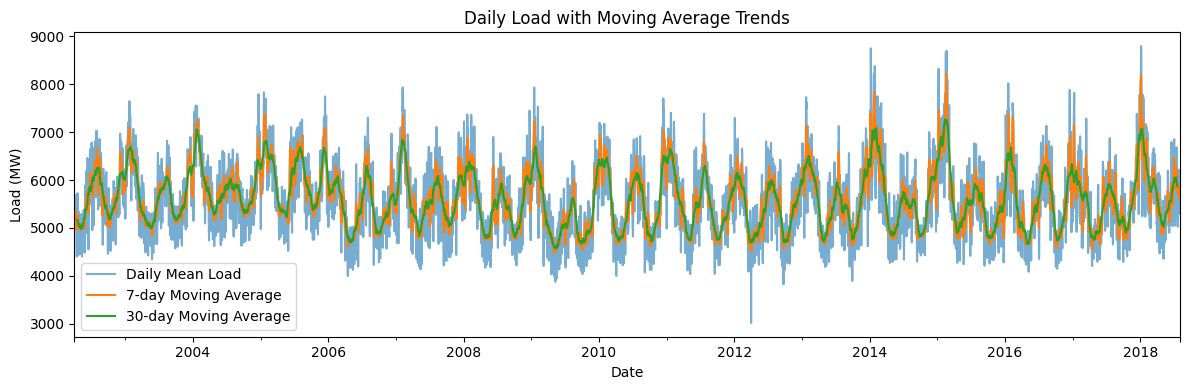

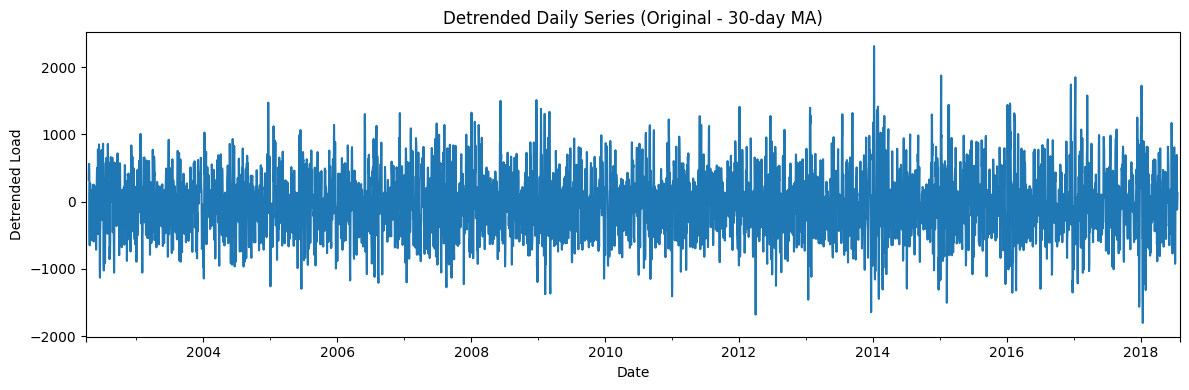

In [21]:
# Aggregate to daily mean to see trend more clearly
daily = ts.resample('D').mean()

plt.figure(figsize=(12, 4))
daily.plot(alpha=0.6, label='Daily Mean Load')

ma_7 = daily.rolling(window=7, center=True).mean()
ma_30 = daily.rolling(window=30, center=True).mean()

ma_7.plot(label='7-day Moving Average')
ma_30.plot(label='30-day Moving Average')

plt.title('Daily Load with Moving Average Trends')
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.legend()
plt.tight_layout()
plt.show()

# Detrend using the 30-day moving average
trend = ma_30
detrended = daily - trend

plt.figure(figsize=(12, 4))
detrended.plot()
plt.title('Detrended Daily Series (Original - 30-day MA)')
plt.xlabel('Date')
plt.ylabel('Detrended Load')
plt.tight_layout()
plt.show()

## Seasonal Decomposition (Trend + Seasonality + Remainder)

Here we:
- Use daily data for 2015–2017.
- Assume **weekly seasonality** (period = 7 days).
- Decompose the series into trend, seasonal, and remainder components.

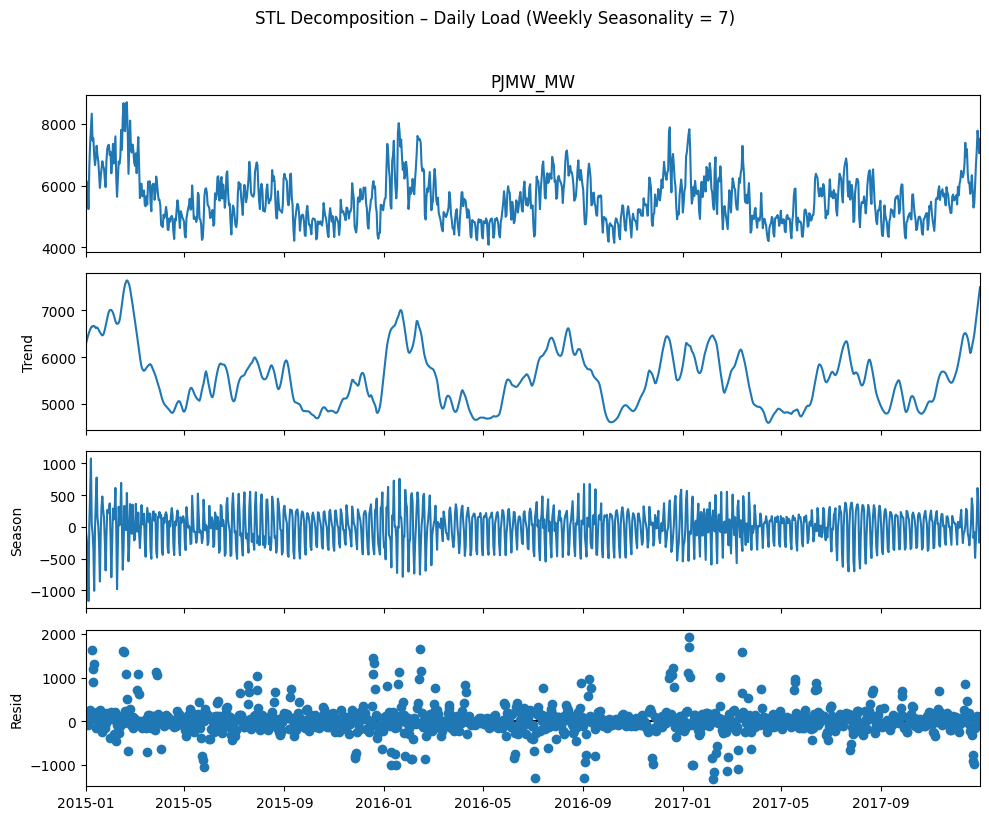

In [22]:
from statsmodels.tsa.seasonal import STL

daily_sub = daily['2015':'2017'].dropna()

# Weekly seasonality: period = 7 (days)
stl = STL(daily_sub, period=7, robust=True)
res = stl.fit()

fig = res.plot()
fig.set_size_inches(10, 8)
plt.suptitle('STL Decomposition – Daily Load (Weekly Seasonality = 7)', y=1.02)
plt.tight_layout()
plt.show()

## Moving Average Example (Table + Plot)

we illustrate a simple moving average in a small table.
Here we:
- Take a short 2-day segment of hourly data.
- Compute a **5-hour moving average**.
- Show the first few rows as a table and plot original vs MA.

In [23]:
# Short example: 2 days of hourly data
example = ts_2017['2017-01-01 00:00':'2017-01-02 23:00'].copy()
example_ma_5 = example.rolling(window=5).mean()

ma_df = pd.DataFrame({
    'Time': example.index,
    'Original': example.values,
    'MA_5': example_ma_5.values
}).head(12)

ma_df

,Time,Original,MA_5
0,2017-01-01 00:00:00,5231.0,NaN
1,2017-01-01 01:00:00,5007.0,NaN
2,2017-01-01 02:00:00,4882.0,NaN
3,2017-01-01 03:00:00,4761.0,NaN
4,2017-01-01 04:00:00,4719.0,4920.0
5,2017-01-01 05:00:00,4721.0,4818.0
6,2017-01-01 06:00:00,4784.0,4773.4
7,2017-01-01 07:00:00,4912.0,4779.4
8,2017-01-01 08:00:00,5081.0,4843.4
9,2017-01-01 09:00:00,5212.0,4942.0


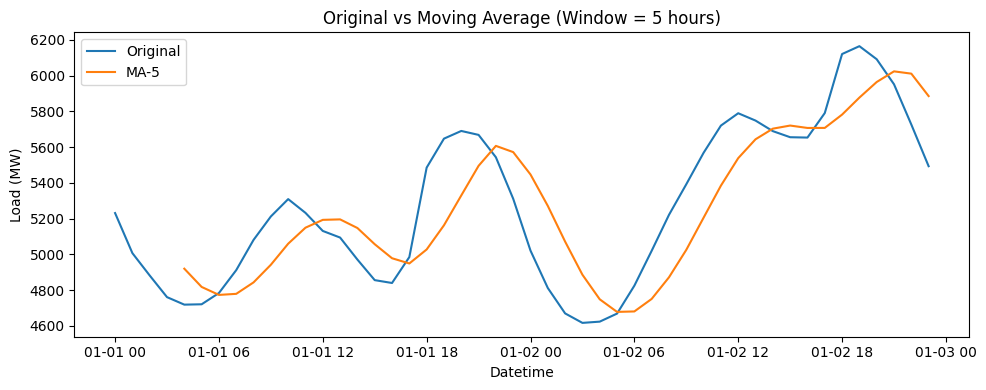

In [24]:
plt.figure(figsize=(10, 4))
plt.plot(example.index, example.values, label='Original')
plt.plot(example.index, example_ma_5.values, label='MA-5')
plt.title('Original vs Moving Average (Window = 5 hours)')
plt.xlabel('Datetime')
plt.ylabel('Load (MW)')
plt.legend()
plt.tight_layout()
plt.show()

## Deseasonalizing with Period-Adjusted Averages

Here we:
1. Aggregate hourly load to **monthly totals**.
2. Compute the **average load for each month** across years.
3. Compute **multiplicative** and **additive** seasonal indices.
4. Deseasonalize the monthly data for a specific year (2017) using multiplicative indices.

In [26]:
# Monthly total load
monthly = ts.resample('M').sum().to_frame(name='Load')
monthly['Year'] = monthly.index.year
monthly['Month'] = monthly.index.month

# Average by month across all years
month_avg = monthly.groupby('Month')['Load'].mean()
overall_avg = month_avg.mean()
print('Overall monthly average load:', overall_avg)

mult_index = month_avg / overall_avg
add_index = month_avg - overall_avg

seasonal_table = pd.DataFrame({
    'Month': range(1, 13),
    'Avg_Load': month_avg.values,
    'Mult_Index': mult_index.values,
    'Add_Index': add_index.values,
})
seasonal_table

Overall monthly average load: 4075629.9335171566


,Month,Avg_Load,Mult_Index,Add_Index
0,1,4.797065e+06,1.177012,721434.878983
1,2,4.269236e+06,1.047503,193606.441483
2,3,4.202408e+06,1.031106,126777.941483
3,4,3.614291e+06,0.886806,-461338.698223
4,5,3.731789e+06,0.915635,-343840.698223
5,6,3.972064e+06,0.974589,-103565.580576
6,7,4.360984e+06,1.070015,285353.654718
7,8,4.093651e+06,1.004422,18021.419424
8,9,3.748228e+06,0.919668,-327402.058517
9,10,3.716684e+06,0.911929,-358945.933517


In [27]:
# Deseasonalize monthly data for 2017 using multiplicative indices
monthly_2017 = monthly[monthly['Year'] == 2017].copy()
monthly_2017['Month'] = monthly_2017.index.month

monthly_2017 = monthly_2017.merge(
    seasonal_table[['Month', 'Mult_Index']],
    on='Month',
    how='left'
)

monthly_2017['Deseasonalized_Load'] = monthly_2017['Load'] / monthly_2017['Mult_Index']
monthly_2017[['Load', 'Mult_Index', 'Deseasonalized_Load']]

,Load,Mult_Index,Deseasonalized_Load
0,4535246.0,1.177012,3.853186e+06
1,3825382.0,1.047503,3.651904e+06
2,4220627.0,1.031106,4.093299e+06
3,3460163.0,0.886806,3.901828e+06
4,3646754.0,0.915635,3.982760e+06
5,3943915.0,0.974589,4.046747e+06
6,4347167.0,1.070015,4.062717e+06
7,4173146.0,1.004422,4.154775e+06
8,3680571.0,0.919668,4.002063e+06
9,3678469.0,0.911929,4.033724e+06


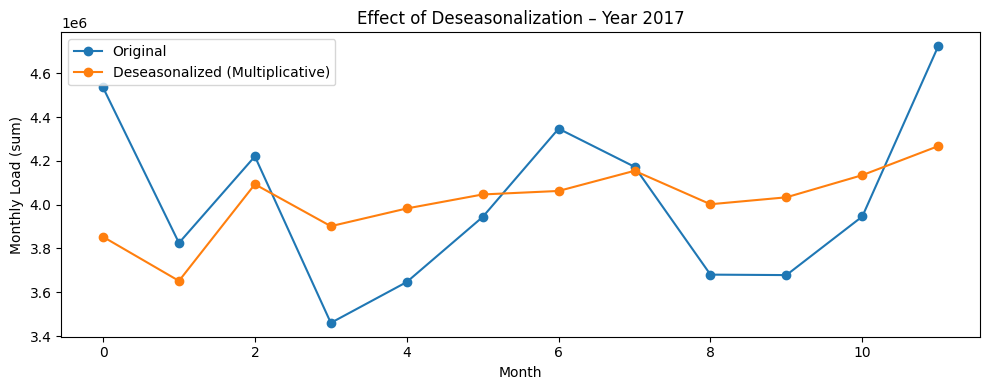

In [28]:
plt.figure(figsize=(10, 4))
plt.plot(monthly_2017.index, monthly_2017['Load'], marker='o', label='Original')
plt.plot(monthly_2017.index, monthly_2017['Deseasonalized_Load'], marker='o',
         label='Deseasonalized (Multiplicative)')
plt.title('Effect of Deseasonalization – Year 2017')
plt.xlabel('Month')
plt.ylabel('Monthly Load (sum)')
plt.legend()
plt.tight_layout()
plt.show()

## Feature Engineering: Lag Features

The slides introduce **lag features** such as:
- $y_{t-1}$ (previous hour)
- $y_{t-24}$ (same hour yesterday)
- $y_{t-168}$ (same hour last week)

Here we create these lag features for January 2017.

In [29]:
feat = ts_2017['2017-01-01':'2017-01-31'].to_frame(name='load')

feat['lag_1'] = feat['load'].shift(1)         # previous hour
feat['lag_24'] = feat['load'].shift(24)       # same hour yesterday
feat['lag_168'] = feat['load'].shift(24 * 7)  # same hour last week

feat.head(10)

,load,lag_1,lag_24,lag_168
Datetime,,,,
2017-01-01 00:00:00,5231.0,NaN,NaN,NaN
2017-01-01 01:00:00,5007.0,5231.0,NaN,NaN
2017-01-01 02:00:00,4882.0,5007.0,NaN,NaN
2017-01-01 03:00:00,4761.0,4882.0,NaN,NaN
2017-01-01 04:00:00,4719.0,4761.0,NaN,NaN
2017-01-01 05:00:00,4721.0,4719.0,NaN,NaN
2017-01-01 06:00:00,4784.0,4721.0,NaN,NaN
2017-01-01 07:00:00,4912.0,4784.0,NaN,NaN
2017-01-01 08:00:00,5081.0,4912.0,NaN,NaN


In [30]:
feat_clean = feat.dropna()
print('Rows after dropping NA:', len(feat_clean))

Rows after dropping NA: 576


## Rolling Window Aggregations

**rolling statistics** (e.g., rolling mean) as another feature type.

Here we compute:
- 3-hour rolling mean
- 24-hour rolling mean

and compare them to the original series.

In [31]:
feat['roll_mean_3'] = feat['load'].rolling(window=3).mean()
feat['roll_mean_24'] = feat['load'].rolling(window=24).mean()

feat.head(10)

,load,lag_1,lag_24,lag_168,roll_mean_3,roll_mean_24
Datetime,,,,,,
2017-01-01 00:00:00,5231.0,NaN,NaN,NaN,NaN,NaN
2017-01-01 01:00:00,5007.0,5231.0,NaN,NaN,NaN,NaN
2017-01-01 02:00:00,4882.0,5007.0,NaN,NaN,5040.000000,NaN
2017-01-01 03:00:00,4761.0,4882.0,NaN,NaN,4883.333333,NaN
2017-01-01 04:00:00,4719.0,4761.0,NaN,NaN,4787.333333,NaN
2017-01-01 05:00:00,4721.0,4719.0,NaN,NaN,4733.666667,NaN
2017-01-01 06:00:00,4784.0,4721.0,NaN,NaN,4741.333333,NaN
2017-01-01 07:00:00,4912.0,4784.0,NaN,NaN,4805.666667,NaN
2017-01-01 08:00:00,5081.0,4912.0,NaN,NaN,4925.666667,NaN


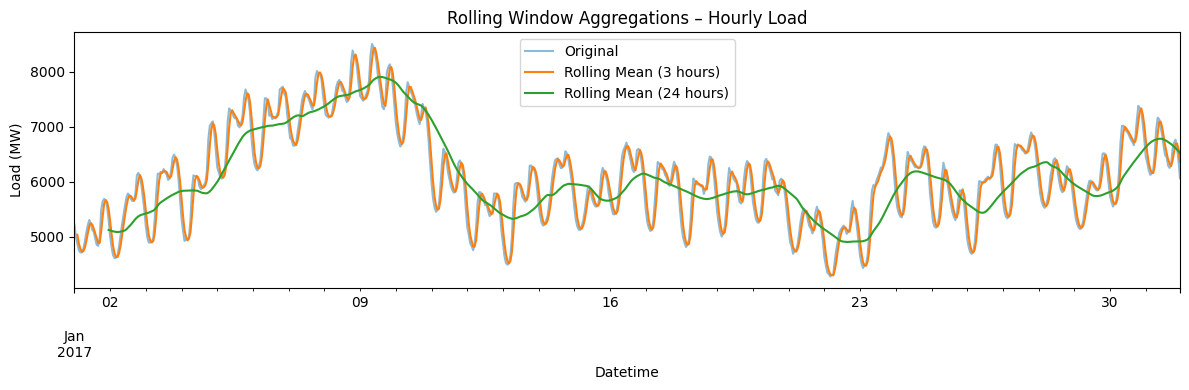

In [32]:
plt.figure(figsize=(12, 4))
feat['load'].plot(alpha=0.5, label='Original')
feat['roll_mean_3'].plot(label='Rolling Mean (3 hours)')
feat['roll_mean_24'].plot(label='Rolling Mean (24 hours)')
plt.title('Rolling Window Aggregations – Hourly Load')
plt.xlabel('Datetime')
plt.ylabel('Load (MW)')
plt.legend()
plt.tight_layout()
plt.show()

## Seasonal Rolling Window Aggregations

**seasonal rolling windows** (e.g., 3-year rolling average for each month).

Here we:
1. Create a Year × Month pivot table of monthly load.
2. Focus on **January** values.
3. Compute a 3-year rolling average for January.

In [33]:
m = monthly.copy()
m['Month'] = m.index.month

pivot = m.pivot_table(values='Load', index='Year', columns='Month')
pivot.head()

Month,1,2,3,4,5,6,7,8,9,10,11,12
Year,,,,,,,,,,,,
2002,NaN,NaN,NaN,3713007.0,3783310.0,4093691.0,4536821.0,4511549.0,3902142.0,3946769.0,4019746.0,4579077.0
2003,4900180.0,4302512.0,4197265.0,3762174.0,3740025.0,3887005.0,4330113.0,4482354.0,3821501.0,3919625.0,3920849.0,4662499.0
2004,5080522.0,4449691.0,4298577.0,3901967.0,4100601.0,4116081.0,4431809.0,4397203.0,4004685.0,3947561.0,4033524.0,4758406.0
2005,4909521.0,4323358.0,4626592.0,3868927.0,3908473.0,4432695.0,4755212.0,4814794.0,4159876.0,4040184.0,4161328.0,4883400.0
2006,4280276.0,4060215.0,4122734.0,3442633.0,3627457.0,3828083.0,4383807.0,4476710.0,3535721.0,3735683.0,3787496.0,4235266.0


In [34]:
jan_series = pivot[1].dropna()
season_roll_3_jan = jan_series.rolling(window=3).mean()

seasonal_roll_table = pd.DataFrame({
    'Year': jan_series.index,
    'Jan_Load': jan_series.values,
    'Jan_Season_Roll_3': season_roll_3_jan.values
})
seasonal_roll_table

,Year,Jan_Load,Jan_Season_Roll_3
0,2003,4900180.0,NaN
1,2004,5080522.0,NaN
2,2005,4909521.0,4.963408e+06
3,2006,4280276.0,4.756773e+06
4,2007,4492344.0,4.560714e+06
5,2008,4663597.0,4.478739e+06
6,2009,4873678.0,4.676540e+06
7,2010,4766421.0,4.767899e+06
8,2011,4860917.0,4.833672e+06
9,2012,4550799.0,4.726046e+06


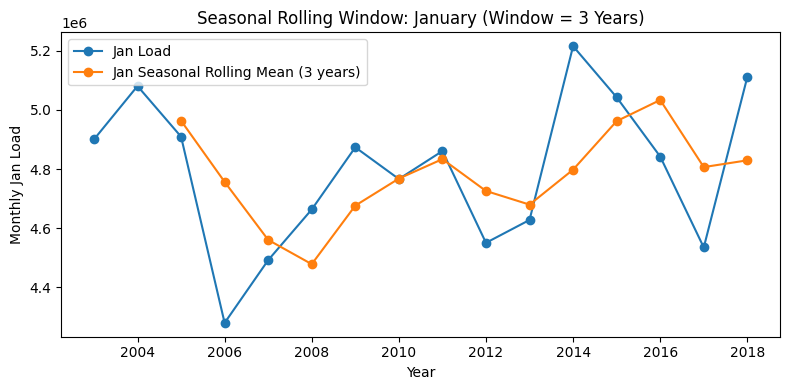

In [35]:
plt.figure(figsize=(8, 4))
plt.plot(seasonal_roll_table['Year'], seasonal_roll_table['Jan_Load'], marker='o', label='Jan Load')
plt.plot(seasonal_roll_table['Year'], seasonal_roll_table['Jan_Season_Roll_3'],
         marker='o', label='Jan Seasonal Rolling Mean (3 years)')
plt.title('Seasonal Rolling Window: January (Window = 3 Years)')
plt.xlabel('Year')
plt.ylabel('Monthly Jan Load')
plt.legend()
plt.tight_layout()
plt.show()

## Forecast Horizon, Point Forecasts, Prediction Intervals
- **Short vs long forecast horizon**
- **One-step vs multi-step forecasts**
- **Point forecasts vs prediction intervals**

Here we implement a very simple **naive (random walk)** model:
- One-step forecast: $\hat{y}_{t+1} = y_t$ (using last observation).
- Multi-step forecast: all future values use the **last training value**.

We also construct a **95% prediction interval** for the multi-step naive forecast using the standard deviation of in-sample residuals.

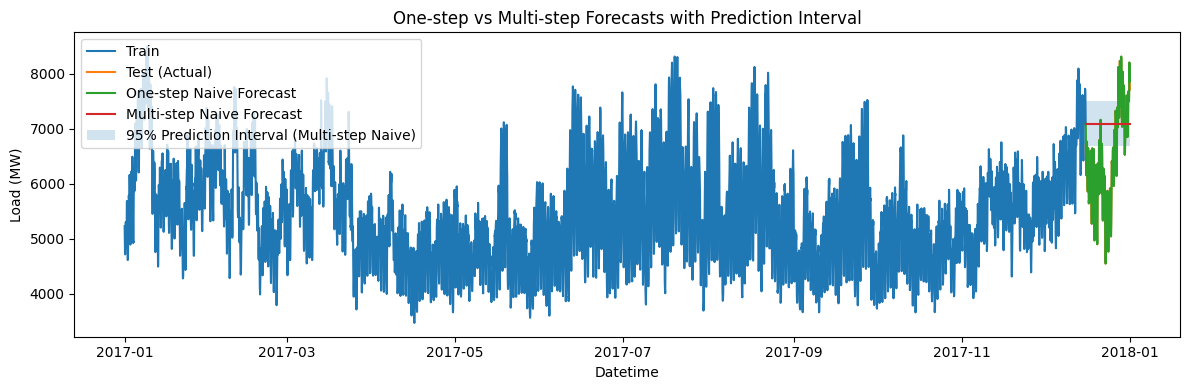

Example point forecast at 2017-12-16 00:00:00: 7096.0 MW
95% prediction interval: [6691.6, 7500.4] MW


In [36]:
# Define train/test split for 2017
train = ts_2017['2017-01-01':'2017-12-15']
test = ts_2017['2017-12-16':'2017-12-31']

# One-step naive forecast (test shifted by one step)
one_step_forecast = test.shift(1).copy()
one_step_forecast.iloc[0] = train.iloc[-1]  # first forecast uses last train value

# Multi-step naive forecast: constant = last train value
multi_step_forecast = pd.Series(train.iloc[-1], index=test.index)

# Compute residuals on train for naive model
train_forecast = train.shift(1)
train_forecast.iloc[0] = train.iloc[0]
residuals = train - train_forecast
sigma = residuals.std()

# 95% prediction interval for multi-step naive
z = 1.96
lower = multi_step_forecast - z * sigma
upper = multi_step_forecast + z * sigma

plt.figure(figsize=(12, 4))
plt.plot(train.index, train.values, label='Train')
plt.plot(test.index, test.values, label='Test (Actual)')
plt.plot(test.index, one_step_forecast.values, label='One-step Naive Forecast')
plt.plot(test.index, multi_step_forecast.values, label='Multi-step Naive Forecast')

plt.fill_between(test.index, lower, upper, alpha=0.2,
                 label='95% Prediction Interval (Multi-step Naive)')

plt.title('One-step vs Multi-step Forecasts with Prediction Interval')
plt.xlabel('Datetime')
plt.ylabel('Load (MW)')
plt.legend()
plt.tight_layout()
plt.show()

# Example numerical output
example_time = test.index[0]
print(f'Example point forecast at {example_time}: {multi_step_forecast.iloc[0]:.1f} MW')
print(f'95% prediction interval: [{lower.iloc[0]:.1f}, {upper.iloc[0]:.1f}] MW')